In the last file, we explored how to reduce a dataframe's memory footprint by selecting the correct column types. We need a different strategy for working with data sets that don't fit into memory even after we've optimized types and filtered columns. Instead of trying to load the full data set into memory, we can load and process it in **chunks**. Here's what that workflow looks like:

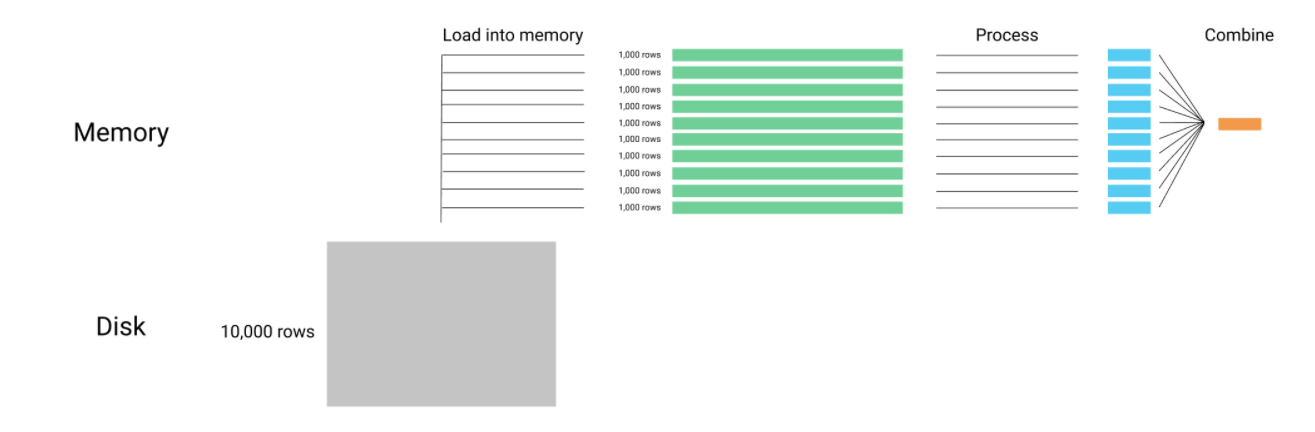

At any given time, only a fraction of the total rows are actually available in memory. Soon after we read the next chunk into memory, Python's garbage collection process removes the old chunk from memory. The downside is that we have to write code that can work with just a portion of the data, store the intermediate results, and combine them at the end. While this is straightforward for simple tasks, it can be cumbersome for complex ones. In this file, we'll explore how to break common tasks down so we can operate on chunks of the data set instead.

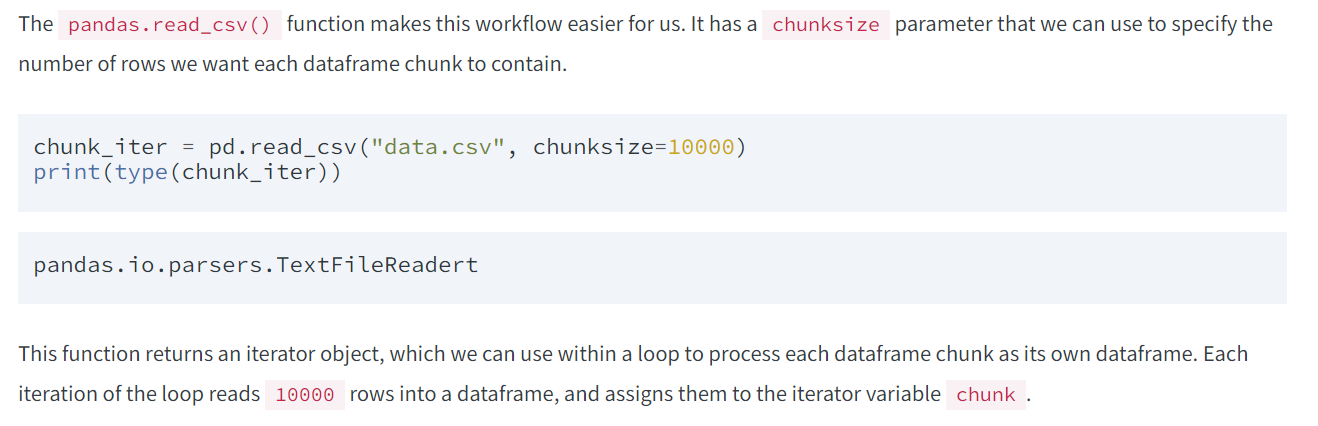

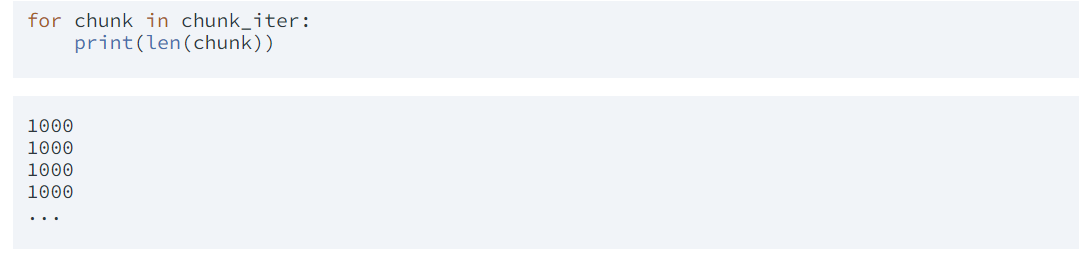

If we recall in an earlier file, the entire data set consumes approximately 45 megabytes of memory by default. If we only have 1 megabyte of memory available, how do we make sure that each dataframe chunk consumes less than that amount so we don't run out of memory? Unfortunately, there's no foolproof way to make sure each chunk is below a specific memory threshold. The best way is to try a small number of rows to start, calculate each dataframe chunk's memory footprint, and then increase the number of rows until we're below 50% of our threshold (just to be safe).

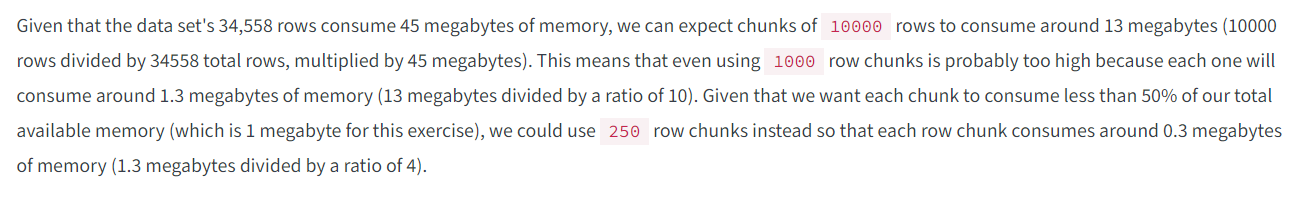

**Task**

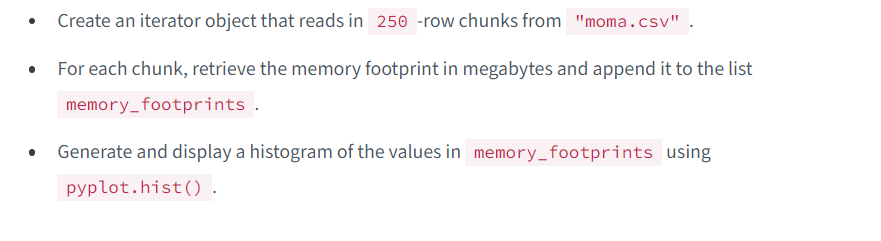

**Answer**

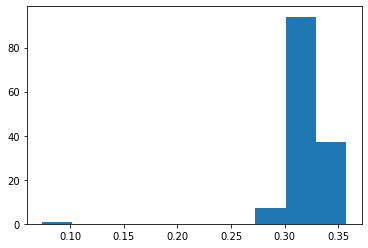

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

memory_footprints = []

chunk_iter = pd.read_csv("moma.csv", chunksize=250)

for chunk in chunk_iter:
    memory_footprints.append(chunk.memory_usage(deep=True).sum()/(1024*1024))

plt.hist(memory_footprints)
plt.show()

It looks like all of the dataframe chunks consumed less than 0.35 megabytes of memory, which was close to what we expected. Now that we know how to select the correct chunk size, let's move on to actually breaking down a simple problem. If we wanted to calculate the total number of rows in a single dataframe, we could use the `len()` function. To do this for many dataframe chunks, we'd need to calculate the number of rows in each chunk and add that value to a counter variable. This workflow should be familiar to us because we work with lists in the same way.

While this exercise may seem simple, it will help us start thinking in terms of working with chunks.

**Task**

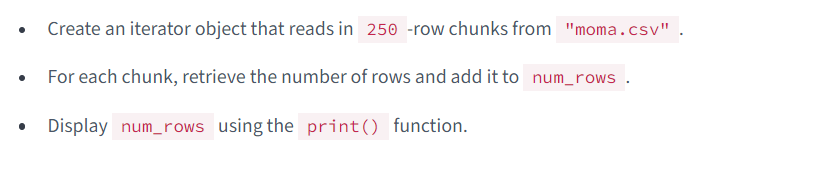

**Answer**

In [2]:
num_rows = 0

chunk_iter = pd.read_csv("moma.csv", chunksize=250)

for chunk in chunk_iter:
    num_rows += len(chunk)
    
print(num_rows)

34558


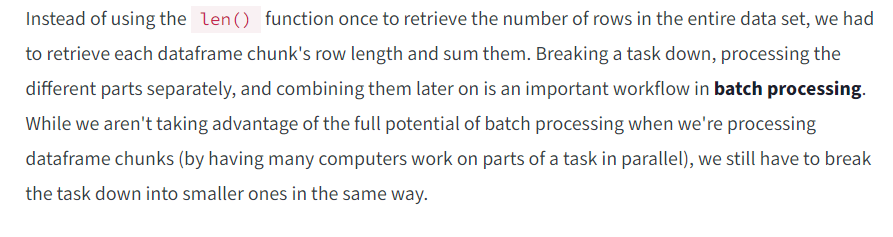

Above we updated a single value (the `num_rows` integer variable) by adding the number of rows in each chunk.

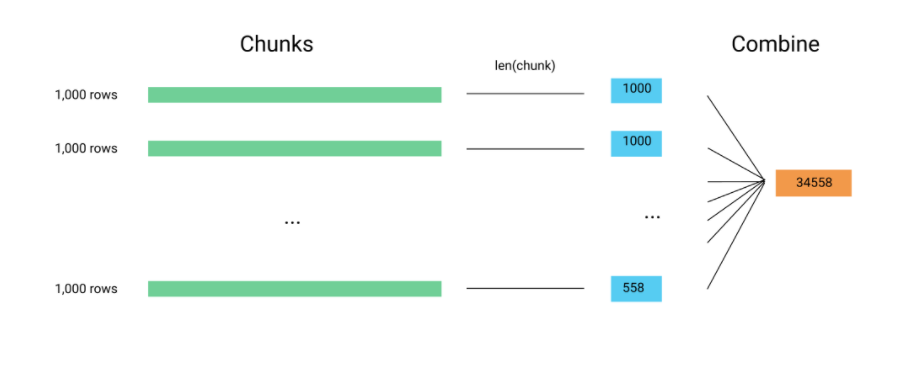

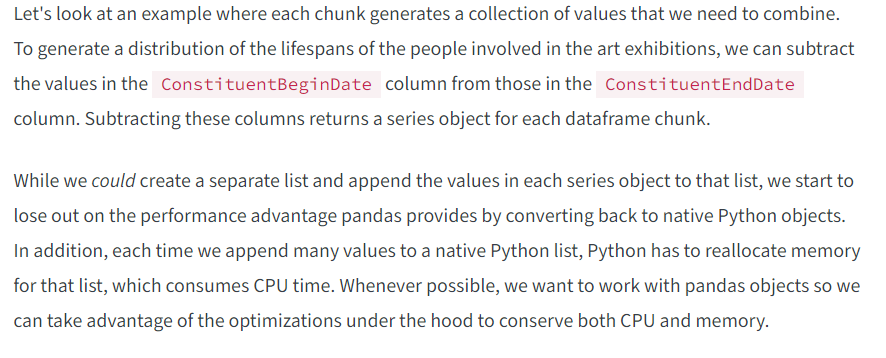

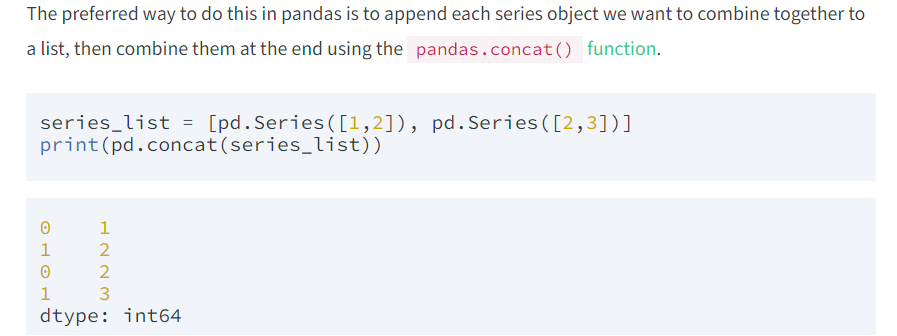

We'll notice that the result preserves the original index values. Thankfully, each value in each of the series objects we'll be generating will have its own unique index value (the row index).

**Task**

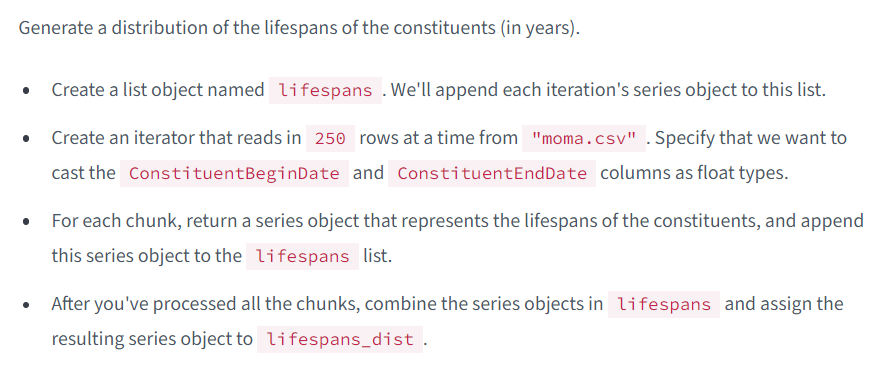

**Answer**

In [4]:
dtypes = {"ConstituentBeginDate": "float", "ConstituentEndDate": "float"}

chunk_iter = pd.read_csv("moma.csv", chunksize=250, dtype=dtypes)

lifespans = []
for chunk in chunk_iter:
    diff = chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate']
    lifespans.append(diff)
    
lifespans_dist = pd.concat(lifespans)
lifespans_dist

0        79.0
1        67.0
2        55.0
3        37.0
4        32.0
         ... 
34553     NaN
34554     NaN
34555     NaN
34556     NaN
34557     NaN
Length: 34558, dtype: float64

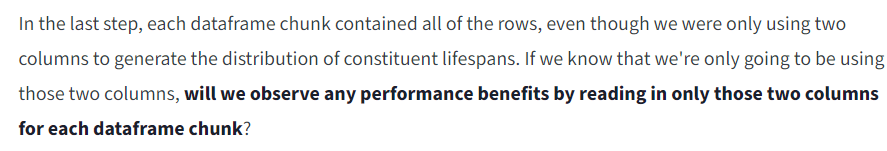

First, let's benchmark how long our implementation from above takes.

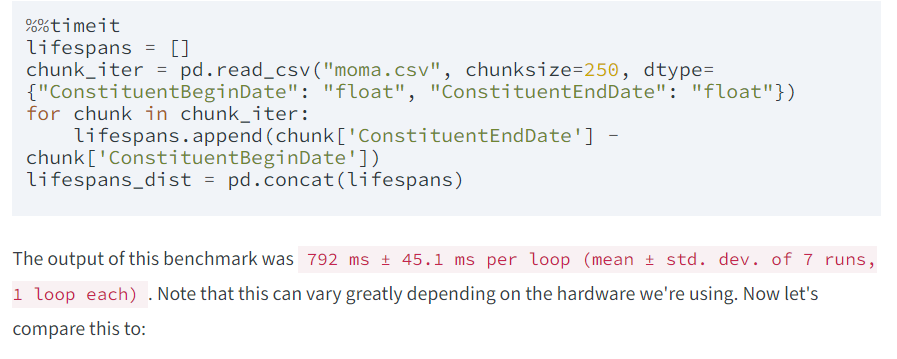

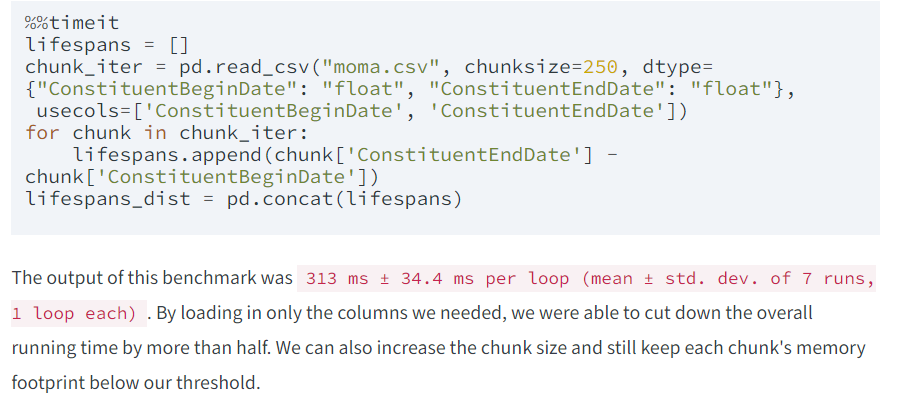

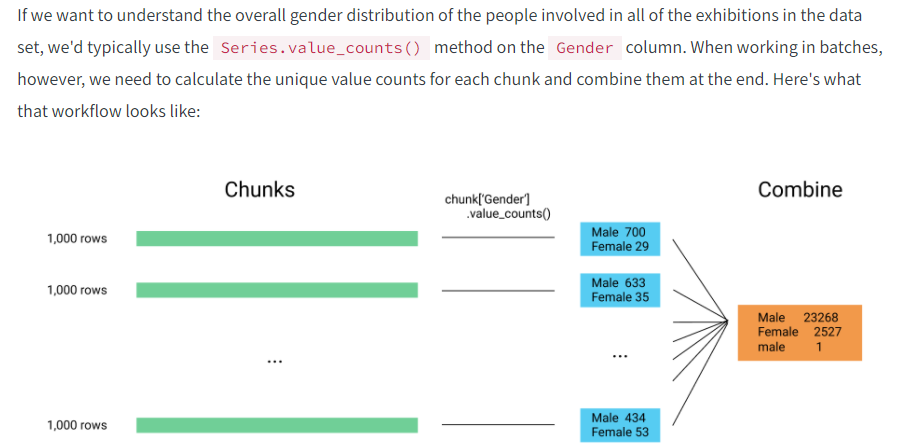

We can use the `pandas.concat()` function to combine all of the chunks at the end.

**Task**

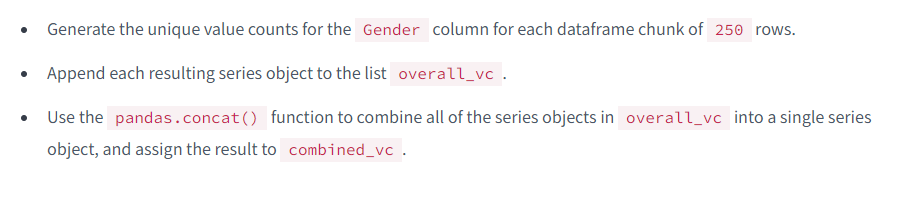

**Answer**

In [6]:
chunk_iter = pd.read_csv("moma.csv", chunksize=250, usecols=['Gender'])

overall_vc = list()
for chunk in chunk_iter:
    chunk_vc = chunk['Gender'].value_counts()
    overall_vc.append(chunk_vc)
    
combined_vc = pd.concat(overall_vc)
combined_vc

Male      208
Female      9
Male      193
Female      6
Male      195
         ... 
Male      186
Female     23
Male      195
Female     30
Male       53
Name: Gender, Length: 278, dtype: int64

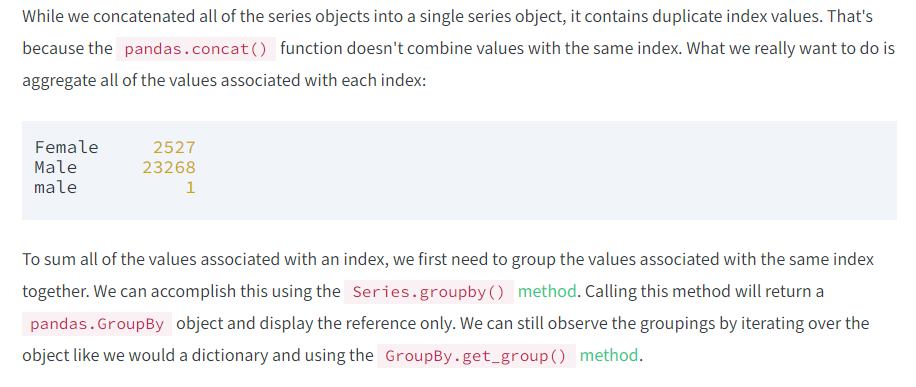

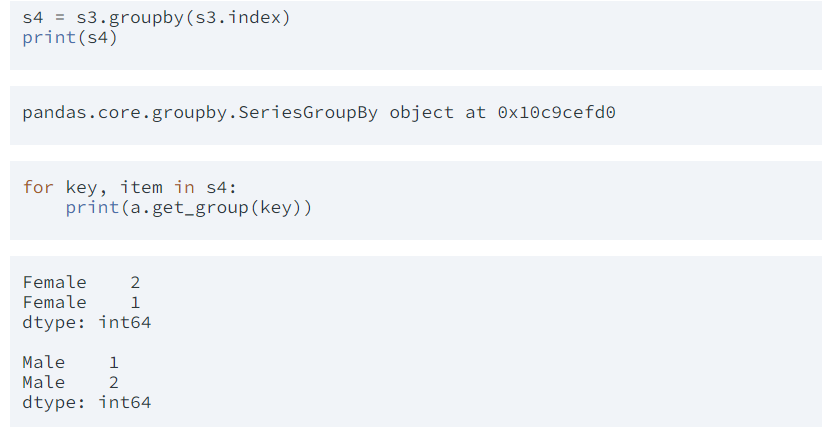

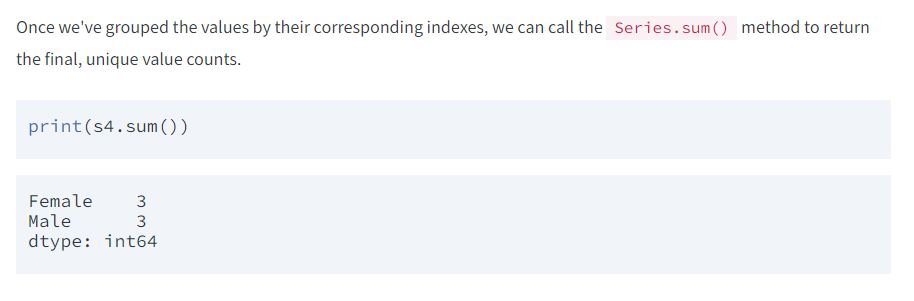

**Task**

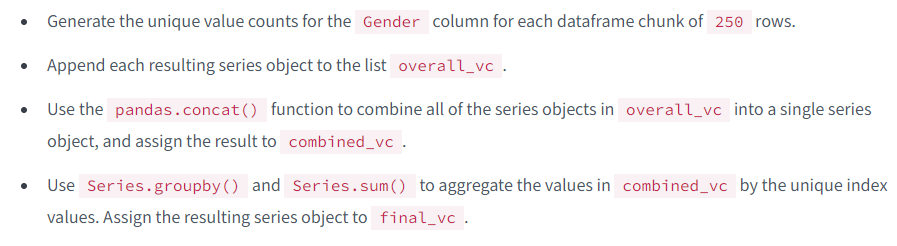

**Answer**

In [7]:
chunk_iter = pd.read_csv("moma.csv", chunksize=250, usecols=['Gender'])

overall_vc = list()
for chunk in chunk_iter:
    chunk_vc = chunk['Gender'].value_counts()
    overall_vc.append(chunk_vc)
    
combined_vc = pd.concat(overall_vc)

final_vc = combined_vc.groupby(combined_vc.index).sum()
final_vc

Female     2527
Male      23268
male          1
Name: Gender, dtype: int64

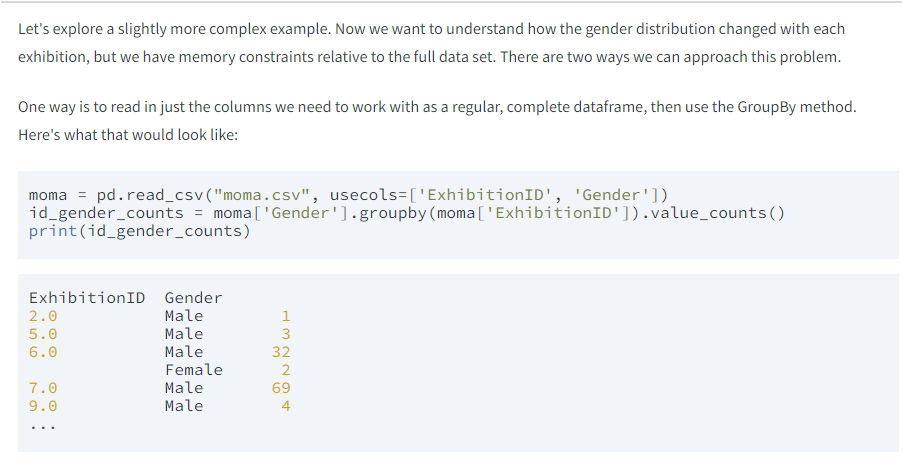

For each unique value in `ExhibitionID`, we have a unique value count for each `Gender`. We can also accomplish the same result through batch processing. 

**Task**

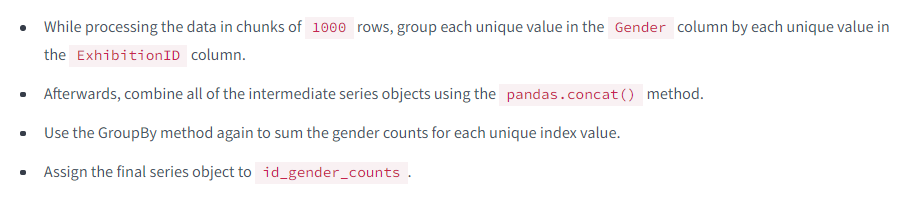

**Answer**

In [8]:
chunk_iter = pd.read_csv("moma.csv", chunksize=250)

df_list = []
for chunk in chunk_iter:
    temp = chunk['Gender'].groupby(chunk['ExhibitionID']).value_counts()
    df_list.append(temp)
    
final_df = pd.concat(df_list)

id_gender_counts = final_df.groupby(final_df.index).sum()
id_gender_counts

(2.0, Male)           1
(5.0, Male)           3
(6.0, Female)         2
(6.0, Male)          32
(7.0, Male)          69
                     ..
(10799.0, Female)     8
(10799.0, Male)      21
(10800.0, Female)     2
(10800.0, Male)       7
(11267.0, Male)       1
Name: Gender, Length: 2214, dtype: int64

In this file, we explored how to work with files that are too big to fit in memory using chunking.